# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [ ]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())

    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [ ]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])

    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Training epoch 9: 100%|███████████████████████| 430/430 [00:13<00:00, 31.63it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.954     0.978     0.966       980
           1      0.971     0.975     0.973      1135
           2      0.939     0.890     0.913      1032
           3      0.894     0.909     0.901      1010
           4      0.916     0.938     0.927       982
           5      0.920     0.873     0.896       892
           6      0.926     0.950     0.938       958
           7      0.921     0.917     0.919      1028
           8      0.880     0.899     0.890       974
           9      0.912     0.900     0.906      1009

    accuracy                          0.924     10000
   macro avg      0.923     0.923     0.923     10000
weighted avg      0.924     0.924     0.924     10000



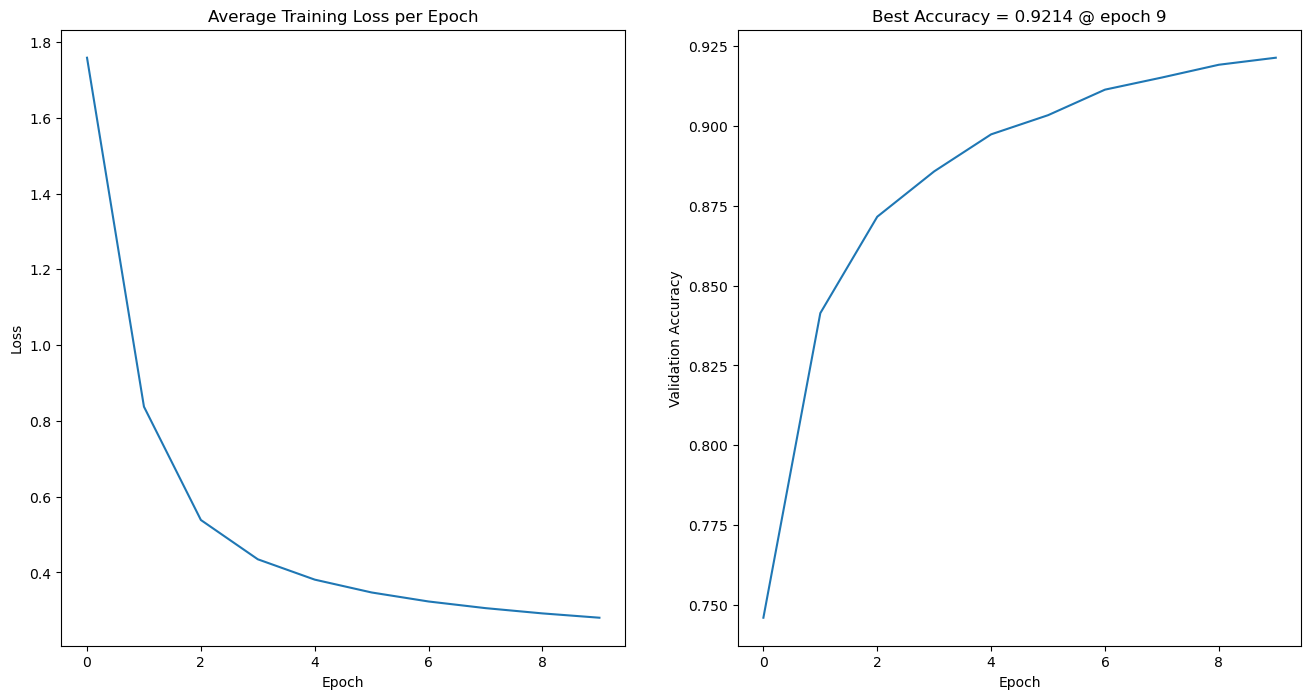

In [ ]:
# Training hyperparameters.
device = 'cpu'
epochs = 10
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [ ]:
# Your code here.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim

In [ ]:
pip install wandb

In [ ]:
import wandb

# Initialize W&B
wandb.login()  # Log in to W&B

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 39


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Prepare the data
transform_mnist = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# Define datasets
train_dataset_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
test_dataset_mnist = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

# Split the test dataset into validation and test sets
val_size = int(0.5 * len(test_dataset_mnist))
test_size = len(test_dataset_mnist) - val_size
val_dataset_mnist, test_dataset_mnist = torch.utils.data.random_split(test_dataset_mnist, [val_size, test_size])



# Define data loaders
batch_size = 64

train_loader_mnist = torch.utils.data.DataLoader(train_dataset_mnist, batch_size=batch_size, shuffle=True)
val_loader_mnist = torch.utils.data.DataLoader(val_dataset_mnist, batch_size=batch_size, shuffle=False)
test_loader_mnist = torch.utils.data.DataLoader(test_dataset_mnist, batch_size=batch_size, shuffle=False)


In [ ]:
# Verify the lengths of the datasets
print(f"Validation dataset size: {len(val_dataset_mnist)}")
print(f"Test dataset size: {len(test_dataset_mnist)}")

Validation dataset size: 5000
Test dataset size: 5000


In [18]:
# Define BaseModel as an abstract base class
class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def forward(self, x):
        raise NotImplementedError("Forward method must be implemented in derived classes.")

    def train_model(self, train_loader, criterion, optimizer, device):
        self.train()
        train_loss = 0.0
        correct = 0
        total = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = 100. * correct / total
        return train_loss, train_acc

    def validate_model(self, val_loader, criterion, device):
        self.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100. * correct / total
        return val_loss, val_acc

    def test_model(self, test_loader, device):
        self.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = self(inputs)
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

        test_acc = 100. * correct / total
        return test_acc


In [ ]:
# Define MLPModel inheriting from BaseModel
class MLPModel(BaseModel):
    def __init__(self, input_size, layer_sizes, output_size):
        super(MLPModel, self).__init__()
        self.layers = []
        prev_size = input_size
        for size in layer_sizes:
            self.layers.append(nn.Linear(prev_size, size))
            self.layers.append(nn.ReLU())
            prev_size = size
        self.layers.append(nn.Linear(prev_size, output_size))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.model(x)
        return x


In [19]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_acc = model.train_model(train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validate the model
        val_loss, val_acc = model.validate_model(val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

                # Log to WandB
        wandb.log({
            "Epoch": epoch + 1,
            "Train Loss": train_loss,
            "Train Accuracy": train_acc,
            "Val Loss": val_loss,
            "Val Accuracy": val_acc
        })

    return train_losses, val_losses, val_accs

def test(model, test_loader, device):
    test_acc = model.test_model(test_loader, device)
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_acc


In [ ]:

mlp_model = MLPModel(input_size=784, layer_sizes=[512, 256, 128], output_size=10)
mlp_model.to(device)

optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_mlp, val_losses_mlp, val_accs_mlp = train(mlp_model, train_loader_mnist, val_loader_mnist,
                                                      criterion, optimizer_mlp, device)

test_acc_mlp = test(mlp_model, test_loader_mnist, device)

wandb.finish()

Epoch [1/10], Train Loss: 0.2251, Train Acc: 93.19%, Val Loss: 0.1033, Val Acc: 96.28%
Epoch [2/10], Train Loss: 0.0931, Train Acc: 97.19%, Val Loss: 0.0901, Val Acc: 97.08%
Epoch [3/10], Train Loss: 0.0665, Train Acc: 97.92%, Val Loss: 0.0801, Val Acc: 97.52%
Epoch [4/10], Train Loss: 0.0519, Train Acc: 98.39%, Val Loss: 0.0822, Val Acc: 97.72%
Epoch [5/10], Train Loss: 0.0406, Train Acc: 98.73%, Val Loss: 0.0714, Val Acc: 98.02%
Epoch [6/10], Train Loss: 0.0368, Train Acc: 98.85%, Val Loss: 0.0786, Val Acc: 97.90%
Epoch [7/10], Train Loss: 0.0323, Train Acc: 98.96%, Val Loss: 0.0618, Val Acc: 98.40%
Epoch [8/10], Train Loss: 0.0269, Train Acc: 99.14%, Val Loss: 0.0796, Val Acc: 98.12%
Epoch [9/10], Train Loss: 0.0277, Train Acc: 99.14%, Val Loss: 0.0743, Val Acc: 98.24%
Epoch [10/10], Train Loss: 0.0218, Train Acc: 99.31%, Val Loss: 0.0728, Val Acc: 98.20%
Test Accuracy: 97.92%


In [ ]:
layer_sizes=[128]
input_size=784
output_size=10

# Launch 5 simulated experiments
total_runs = 5
for run in range(total_runs):
  # 🐝 1️⃣ Start a new run to track this script
  wandb.init(
      # Set the project where this run will be logged
      project="MLP_perf",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_{run}",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.001,
      "architecture": "MLP",
      "dataset": "MNIST",
      "epochs": 10,
      })


  layer_sizes.insert(0, layer_sizes[0]*2)
  layer_sizes_str = ', '.join(map(str, layer_sizes))

  print("Hidden layer sizes: " + layer_sizes_str)

  mlp_model = MLPModel(input_size, layer_sizes, output_size)
  mlp_model.to(device)

  optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train_losses_mlp, val_losses_mlp, val_accs_mlp = train(mlp_model, train_loader_mnist, val_loader_mnist,
                                                      criterion, optimizer_mlp, device)

  test_acc_mlp = test(mlp_model, test_loader_mnist, device)
  wandb.summary['test_accuracy'] = test_acc_mlp

  wandb.finish()

Hidden layer sizes: 256, 128
Epoch [1/10], Train Loss: 0.2276, Train Acc: 93.17%, Val Loss: 0.1148, Val Acc: 96.56%
Epoch [2/10], Train Loss: 0.0937, Train Acc: 97.15%, Val Loss: 0.1145, Val Acc: 96.28%
Epoch [3/10], Train Loss: 0.0656, Train Acc: 97.90%, Val Loss: 0.0887, Val Acc: 97.12%
Epoch [4/10], Train Loss: 0.0504, Train Acc: 98.38%, Val Loss: 0.0848, Val Acc: 97.64%
Epoch [5/10], Train Loss: 0.0417, Train Acc: 98.62%, Val Loss: 0.0848, Val Acc: 97.38%
Epoch [6/10], Train Loss: 0.0325, Train Acc: 98.91%, Val Loss: 0.0740, Val Acc: 97.96%
Epoch [7/10], Train Loss: 0.0283, Train Acc: 99.05%, Val Loss: 0.0882, Val Acc: 97.70%
Epoch [8/10], Train Loss: 0.0256, Train Acc: 99.14%, Val Loss: 0.0964, Val Acc: 97.38%
Epoch [9/10], Train Loss: 0.0204, Train Acc: 99.31%, Val Loss: 0.0974, Val Acc: 97.82%
Epoch [10/10], Train Loss: 0.0201, Train Acc: 99.32%, Val Loss: 0.0958, Val Acc: 97.76%
Test Accuracy: 97.92%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▆▆▇▇█████
Train Loss,█▃▃▂▂▁▁▁▁▁
Val Accuracy,▂▁▅▇▆█▇▆▇▇
Val Loss,██▄▃▃▁▃▅▅▅
Epoch,10
Train Accuracy,99.31667
Train Loss,0.0201
Val Accuracy,97.76
Val Loss,0.0958
test_accuracy,97.92


Hidden layer sizes: 512, 256, 128
Epoch [1/10], Train Loss: 0.2236, Train Acc: 93.16%, Val Loss: 0.1018, Val Acc: 97.20%
Epoch [2/10], Train Loss: 0.0960, Train Acc: 97.09%, Val Loss: 0.0934, Val Acc: 97.18%
Epoch [3/10], Train Loss: 0.0678, Train Acc: 97.90%, Val Loss: 0.0977, Val Acc: 96.86%
Epoch [4/10], Train Loss: 0.0525, Train Acc: 98.37%, Val Loss: 0.0687, Val Acc: 98.00%
Epoch [5/10], Train Loss: 0.0419, Train Acc: 98.68%, Val Loss: 0.0955, Val Acc: 97.40%
Epoch [6/10], Train Loss: 0.0365, Train Acc: 98.86%, Val Loss: 0.0897, Val Acc: 97.58%
Epoch [7/10], Train Loss: 0.0291, Train Acc: 99.04%, Val Loss: 0.1034, Val Acc: 97.60%
Epoch [8/10], Train Loss: 0.0272, Train Acc: 99.17%, Val Loss: 0.0817, Val Acc: 98.20%
Epoch [9/10], Train Loss: 0.0255, Train Acc: 99.22%, Val Loss: 0.0776, Val Acc: 98.04%
Epoch [10/10], Train Loss: 0.0213, Train Acc: 99.32%, Val Loss: 0.0934, Val Acc: 98.14%
Test Accuracy: 98.00%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Val Accuracy,▃▃▁▇▄▅▅█▇█
Val Loss,█▆▇▁▆▅█▄▃▆
Epoch,10
Train Accuracy,99.31833
Train Loss,0.02126
Val Accuracy,98.14
Val Loss,0.09344
test_accuracy,98.0


Hidden layer sizes: 1024, 512, 256, 128
Epoch [1/10], Train Loss: 0.2329, Train Acc: 92.94%, Val Loss: 0.1292, Val Acc: 95.84%
Epoch [2/10], Train Loss: 0.1009, Train Acc: 97.01%, Val Loss: 0.1079, Val Acc: 96.66%
Epoch [3/10], Train Loss: 0.0719, Train Acc: 97.89%, Val Loss: 0.0954, Val Acc: 97.02%
Epoch [4/10], Train Loss: 0.0579, Train Acc: 98.27%, Val Loss: 0.0912, Val Acc: 97.54%
Epoch [5/10], Train Loss: 0.0476, Train Acc: 98.61%, Val Loss: 0.0941, Val Acc: 97.20%
Epoch [6/10], Train Loss: 0.0423, Train Acc: 98.71%, Val Loss: 0.0853, Val Acc: 97.98%
Epoch [7/10], Train Loss: 0.0336, Train Acc: 99.03%, Val Loss: 0.1091, Val Acc: 97.38%
Epoch [8/10], Train Loss: 0.0317, Train Acc: 99.11%, Val Loss: 0.0729, Val Acc: 98.10%
Epoch [9/10], Train Loss: 0.0287, Train Acc: 99.17%, Val Loss: 0.0783, Val Acc: 98.28%
Epoch [10/10], Train Loss: 0.0258, Train Acc: 99.28%, Val Loss: 0.0727, Val Acc: 98.06%
Test Accuracy: 97.96%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▅▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Val Accuracy,▁▃▄▆▅▇▅▇█▇
Val Loss,█▅▄▃▄▃▆▁▂▁
Epoch,10
Train Accuracy,99.27667
Train Loss,0.02581
Val Accuracy,98.06
Val Loss,0.07274
test_accuracy,97.96


Hidden layer sizes: 2048, 1024, 512, 256, 128
Epoch [1/10], Train Loss: 0.2521, Train Acc: 92.36%, Val Loss: 0.1467, Val Acc: 95.94%
Epoch [2/10], Train Loss: 0.1134, Train Acc: 96.91%, Val Loss: 0.1342, Val Acc: 96.62%
Epoch [3/10], Train Loss: 0.0842, Train Acc: 97.64%, Val Loss: 0.0975, Val Acc: 97.54%
Epoch [4/10], Train Loss: 0.0709, Train Acc: 97.97%, Val Loss: 0.0883, Val Acc: 97.98%
Epoch [5/10], Train Loss: 0.0551, Train Acc: 98.45%, Val Loss: 0.1112, Val Acc: 97.34%
Epoch [6/10], Train Loss: 0.0513, Train Acc: 98.62%, Val Loss: 0.1113, Val Acc: 97.28%
Epoch [7/10], Train Loss: 0.0430, Train Acc: 98.85%, Val Loss: 0.1000, Val Acc: 97.98%
Epoch [8/10], Train Loss: 0.0388, Train Acc: 98.97%, Val Loss: 0.0886, Val Acc: 98.24%
Epoch [9/10], Train Loss: 0.0306, Train Acc: 99.18%, Val Loss: 0.0696, Val Acc: 98.24%
Epoch [10/10], Train Loss: 0.0300, Train Acc: 99.15%, Val Loss: 0.0903, Val Acc: 98.02%
Test Accuracy: 98.12%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▆▆▇▇▇████
Train Loss,█▄▃▂▂▂▁▁▁▁
Val Accuracy,▁▃▆▇▅▅▇██▇
Val Loss,█▇▄▃▅▅▄▃▁▃
Epoch,10
Train Accuracy,99.14833
Train Loss,0.03
Val Accuracy,98.02
Val Loss,0.09029
test_accuracy,98.12


Hidden layer sizes: 4096, 2048, 1024, 512, 256, 128
Epoch [1/10], Train Loss: 0.2907, Train Acc: 91.69%, Val Loss: 0.1387, Val Acc: 96.32%
Epoch [2/10], Train Loss: 0.1401, Train Acc: 96.60%, Val Loss: 0.1565, Val Acc: 96.18%
Epoch [3/10], Train Loss: 0.0998, Train Acc: 97.39%, Val Loss: 0.1114, Val Acc: 97.04%
Epoch [4/10], Train Loss: 0.0794, Train Acc: 98.05%, Val Loss: 0.0961, Val Acc: 97.62%
Epoch [5/10], Train Loss: 0.0693, Train Acc: 98.27%, Val Loss: 0.1132, Val Acc: 97.62%
Epoch [6/10], Train Loss: 0.0568, Train Acc: 98.59%, Val Loss: 0.1062, Val Acc: 97.56%
Epoch [7/10], Train Loss: 0.0515, Train Acc: 98.66%, Val Loss: 0.1226, Val Acc: 97.72%
Epoch [8/10], Train Loss: 0.0549, Train Acc: 98.69%, Val Loss: 0.0862, Val Acc: 98.14%
Epoch [9/10], Train Loss: 0.0370, Train Acc: 99.11%, Val Loss: 0.0893, Val Acc: 97.94%
Epoch [10/10], Train Loss: 0.0415, Train Acc: 99.02%, Val Loss: 0.0952, Val Acc: 98.22%
Test Accuracy: 97.72%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▆▆▇▇█████
Train Loss,█▄▃▂▂▂▁▁▁▁
Val Accuracy,▁▁▄▆▆▆▆█▇█
Val Loss,▆█▄▂▄▃▅▁▁▂
Epoch,10
Train Accuracy,99.01667
Train Loss,0.04145
Val Accuracy,98.22
Val Loss,0.09516
test_accuracy,97.72


### Findings

As shown by the results of our experiments, adding layers to a MLP does not improve its performance!

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [ ]:
# Your code here.

In [17]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


train_dataset_cifar = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_cifar)
test_dataset_cifar = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_cifar)

# Split the test dataset into validation and test sets
val_size = int(0.5 * len(test_dataset_cifar))
test_size = len(test_dataset_cifar) - val_size
val_dataset_cifar, test_dataset_cifar = torch.utils.data.random_split(test_dataset_cifar, [val_size, test_size])

batch_size = 64

train_loader_cifar = torch.utils.data.DataLoader(train_dataset_cifar, batch_size=batch_size, shuffle=True)
val_loader_cifar = torch.utils.data.DataLoader(val_dataset_cifar, batch_size=batch_size, shuffle=False)
test_loader_cifar = torch.utils.data.DataLoader(test_dataset_cifar, batch_size=batch_size, shuffle=False)

# Class labels in CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 99824149.48it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Verify the lengths of the datasets
print(f"Validation dataset size: {len(val_dataset_cifar)}")
print(f"Test dataset size: {len(test_dataset_cifar)}")

Validation dataset size: 5000
Test dataset size: 5000


In [20]:

# Define CNNModel inheriting from BaseModel
class CNNModel(BaseModel):
    def __init__(self, layer_channels, fc_sizes, output_size):
        super(CNNModel, self).__init__()
        self.conv_layers = []
        i = 0
        prev_channels = 3  # Assuming RGB input
        for channels in layer_channels:
            self.conv_layers.append(nn.Conv2d(prev_channels, channels, kernel_size=3, padding=1))
            self.conv_layers.append(nn.ReLU())
            self.conv_layers.append(nn.MaxPool2d(2, 2))
            prev_channels = channels
            i = i + 1
        self.conv_layers = nn.Sequential(*self.conv_layers)

        # Calculate input size for fully connected layers
        # Assuming input image size of 32x32 after pooling layers
        x = 32 // 2 ** i
        input_size = prev_channels * x * x
        self.fc_layers = []
        prev_size = input_size
        for size in fc_sizes:
            self.fc_layers.append(nn.Linear(prev_size, size))
            self.fc_layers.append(nn.ReLU())
            prev_size = size
        self.fc_layers.append(nn.Linear(prev_size, output_size))
        self.fc_model = nn.Sequential(*self.fc_layers)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Flatten for fully connected layers
        x = self.fc_model(x)
        return x



In [ ]:

cnn_model = CNNModel(layer_channels=[32, 64], fc_sizes=[512], output_size=10)
cnn_model.to(device)

optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_cnn, val_losses_cnn, val_accs_cnn = train(cnn_model, train_loader_cifar, val_loader_cifar,
                                                       criterion, optimizer_cnn, device)

test_acc_cnn = test(cnn_model, test_loader_cifar, device)

Epoch [1/5], Train Loss: 1.2390, Train Acc: 55.56%, Val Loss: 0.9965, Val Acc: 65.02%
Epoch [2/5], Train Loss: 0.8356, Train Acc: 70.72%, Val Loss: 0.8478, Val Acc: 70.94%
Epoch [3/5], Train Loss: 0.6436, Train Acc: 77.30%, Val Loss: 0.7914, Val Acc: 72.78%
Epoch [4/5], Train Loss: 0.4757, Train Acc: 83.34%, Val Loss: 0.8568, Val Acc: 72.64%
Epoch [5/5], Train Loss: 0.3197, Train Acc: 88.81%, Val Loss: 0.8625, Val Acc: 73.76%
Test Accuracy: 73.40%


In [ ]:
layer_channels=[32]
fc_sizes=[512]
output_size=10

# Launch 3simulated experiments
total_runs = 4
for run in range(total_runs):
  # 🐝 1️⃣ Start a new run to track this script
  wandb.init(
      # Set the project where this run will be logged
      project="CNN_perf2",
      # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
      name=f"experiment_{run + 1}",
      # Track hyperparameters and run metadata
      config={
      "learning_rate": 0.001,
      "architecture": "CNN",
      "dataset": "CIFAR-10",
      "epochs": 10,
      })


  layer_channels.append(layer_channels[-1]*2)
  layer_channels_str = ', '.join(map(str, layer_channels))


  print("CNN sizes: " + layer_channels_str)


  cnn_model = CNNModel(layer_channels, fc_sizes, output_size)
  cnn_model.to(device)

  optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  train_losses_cnn, val_losses_cnn, val_accs_cnn = train(cnn_model, train_loader_cifar, val_loader_cifar,
                                                       criterion, optimizer_cnn, device)

  test_acc_cnn = test(cnn_model, test_loader_cifar, device)

  wandb.summary["CNN sizes"] = layer_channels_str

  wandb.summary['test_accuracy'] = test_acc_cnn

  wandb.finish()

CNN sizes: 32, 64
Epoch [1/10], Train Loss: 1.2385, Train Acc: 55.66%, Val Loss: 0.9737, Val Acc: 65.34%
Epoch [2/10], Train Loss: 0.8511, Train Acc: 69.98%, Val Loss: 0.8423, Val Acc: 70.76%
Epoch [3/10], Train Loss: 0.6535, Train Acc: 77.11%, Val Loss: 0.8323, Val Acc: 71.82%
Epoch [4/10], Train Loss: 0.4837, Train Acc: 83.04%, Val Loss: 0.7987, Val Acc: 73.58%
Epoch [5/10], Train Loss: 0.3259, Train Acc: 88.64%, Val Loss: 0.9015, Val Acc: 72.16%
Epoch [6/10], Train Loss: 0.1979, Train Acc: 93.17%, Val Loss: 1.0374, Val Acc: 72.94%
Epoch [7/10], Train Loss: 0.1234, Train Acc: 95.83%, Val Loss: 1.1641, Val Acc: 72.62%
Epoch [8/10], Train Loss: 0.0912, Train Acc: 96.89%, Val Loss: 1.3703, Val Acc: 71.88%
Epoch [9/10], Train Loss: 0.0833, Train Acc: 97.11%, Val Loss: 1.4212, Val Acc: 71.90%
Epoch [10/10], Train Loss: 0.0735, Train Acc: 97.58%, Val Loss: 1.5819, Val Acc: 71.82%
Test Accuracy: 72.48%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▃▅▆▇▇████
Train Loss,█▆▄▃▃▂▁▁▁▁
Val Accuracy,▁▆▇█▇▇▇▇▇▇
Val Loss,▃▁▁▁▂▃▄▆▇█
CNN sizes,"32, 64"
Epoch,10
Train Accuracy,97.578
Train Loss,0.07347
Val Accuracy,71.82
Val Loss,1.58186


CNN sizes: 32, 64, 128
Epoch [1/10], Train Loss: 1.3156, Train Acc: 52.47%, Val Loss: 0.9744, Val Acc: 66.12%
Epoch [2/10], Train Loss: 0.8596, Train Acc: 69.83%, Val Loss: 0.8155, Val Acc: 71.64%
Epoch [3/10], Train Loss: 0.6732, Train Acc: 76.53%, Val Loss: 0.7428, Val Acc: 73.82%
Epoch [4/10], Train Loss: 0.5327, Train Acc: 81.20%, Val Loss: 0.7268, Val Acc: 75.54%
Epoch [5/10], Train Loss: 0.4111, Train Acc: 85.48%, Val Loss: 0.7852, Val Acc: 75.26%
Epoch [6/10], Train Loss: 0.3095, Train Acc: 88.97%, Val Loss: 0.8414, Val Acc: 76.00%
Epoch [7/10], Train Loss: 0.2183, Train Acc: 92.27%, Val Loss: 0.8595, Val Acc: 76.70%
Epoch [8/10], Train Loss: 0.1639, Train Acc: 94.23%, Val Loss: 0.9865, Val Acc: 75.84%
Epoch [9/10], Train Loss: 0.1299, Train Acc: 95.46%, Val Loss: 1.1233, Val Acc: 74.84%
Epoch [10/10], Train Loss: 0.1057, Train Acc: 96.27%, Val Loss: 1.2459, Val Acc: 75.98%
Test Accuracy: 76.04%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▄▅▆▆▇▇███
Train Loss,█▅▄▃▃▂▂▁▁▁
Val Accuracy,▁▅▆▇▇██▇▇█
Val Loss,▄▂▁▁▂▃▃▅▆█
CNN sizes,"32, 64, 128"
Epoch,10
Train Accuracy,96.272
Train Loss,0.10572
Val Accuracy,75.98
Val Loss,1.24587


CNN sizes: 32, 64, 128, 256
Epoch [1/10], Train Loss: 1.3781, Train Acc: 49.29%, Val Loss: 1.0292, Val Acc: 63.92%
Epoch [2/10], Train Loss: 0.8791, Train Acc: 68.95%, Val Loss: 0.8043, Val Acc: 71.30%
Epoch [3/10], Train Loss: 0.6815, Train Acc: 76.07%, Val Loss: 0.7276, Val Acc: 74.80%
Epoch [4/10], Train Loss: 0.5434, Train Acc: 81.02%, Val Loss: 0.6877, Val Acc: 76.28%
Epoch [5/10], Train Loss: 0.4349, Train Acc: 84.88%, Val Loss: 0.7173, Val Acc: 75.66%
Epoch [6/10], Train Loss: 0.3399, Train Acc: 87.89%, Val Loss: 0.7652, Val Acc: 76.66%
Epoch [7/10], Train Loss: 0.2600, Train Acc: 90.76%, Val Loss: 0.8699, Val Acc: 75.82%
Epoch [8/10], Train Loss: 0.2043, Train Acc: 92.82%, Val Loss: 0.9553, Val Acc: 75.36%
Epoch [9/10], Train Loss: 0.1752, Train Acc: 93.79%, Val Loss: 1.0594, Val Acc: 75.62%
Epoch [10/10], Train Loss: 0.1401, Train Acc: 94.99%, Val Loss: 1.2126, Val Acc: 75.42%
Test Accuracy: 75.02%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▄▅▆▆▇▇███
Train Loss,█▅▄▃▃▂▂▁▁▁
Val Accuracy,▁▅▇█▇██▇▇▇
Val Loss,▆▃▂▁▁▂▃▅▆█
CNN sizes,"32, 64, 128, 256"
Epoch,10
Train Accuracy,94.994
Train Loss,0.14007
Val Accuracy,75.42
Val Loss,1.21262


CNN sizes: 32, 64, 128, 256, 512
Epoch [1/10], Train Loss: 1.4418, Train Acc: 46.52%, Val Loss: 1.1013, Val Acc: 60.66%
Epoch [2/10], Train Loss: 0.9449, Train Acc: 66.45%, Val Loss: 0.8968, Val Acc: 69.72%
Epoch [3/10], Train Loss: 0.7226, Train Acc: 74.77%, Val Loss: 0.7956, Val Acc: 73.02%
Epoch [4/10], Train Loss: 0.5869, Train Acc: 79.54%, Val Loss: 0.7885, Val Acc: 73.48%
Epoch [5/10], Train Loss: 0.4771, Train Acc: 83.25%, Val Loss: 0.7687, Val Acc: 75.34%
Epoch [6/10], Train Loss: 0.3836, Train Acc: 86.72%, Val Loss: 0.7527, Val Acc: 75.96%
Epoch [7/10], Train Loss: 0.2988, Train Acc: 89.43%, Val Loss: 0.8717, Val Acc: 75.80%
Epoch [8/10], Train Loss: 0.2401, Train Acc: 91.60%, Val Loss: 0.9273, Val Acc: 75.14%
Epoch [9/10], Train Loss: 0.2040, Train Acc: 92.88%, Val Loss: 1.0677, Val Acc: 73.22%
Epoch [10/10], Train Loss: 0.1615, Train Acc: 94.42%, Val Loss: 1.0317, Val Acc: 74.78%
Test Accuracy: 74.76%


Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▄▅▆▆▇▇███
Train Loss,█▅▄▃▃▂▂▁▁▁
Val Accuracy,▁▅▇▇████▇▇
Val Loss,█▄▂▂▁▁▃▅▇▇
CNN sizes,"32, 64, 128, 256, 51..."
Epoch,10
Train Accuracy,94.422
Train Loss,0.16153
Val Accuracy,74.78
Val Loss,1.03167


### Findings

As shown by the results of our experiments, adding layers in a CNN does not improve its performance!

In [142]:
#IMPLEMENTATION OF A CNN WITH RESIDUAL CONNECTIONS

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet2(BaseModel):
    def __init__(self, num_classes=10):
        super(ResNet2, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        strides = [stride] + [1] * (blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


In [ ]:
run = 0
wandb.init(
    # Set the project where this run will be logged
    project="ResNet2_perf",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"experiment_{run}",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.001,
    "architecture": "ResNet2",
    "dataset": "Cifar-10",
    "epochs": 10,
    })

r = ResNet2(num_classes=10).to(device)


# criterion, optimizer and dataloaders
criterion = nn.CrossEntropyLoss()
optimizer_r = torch.optim.Adam(r.parameters(), lr=0.001)

# Assuming train_loader, val_loader, test_loader are defined
train_losses_r, val_losses_r, val_accs_r = train(r, train_loader_cifar, val_loader_cifar,
                                                       criterion, optimizer_r, device)


test_acc_r = test(r, test_loader_cifar, device)

torch.save(rn.state_dict(), 'cifar10-resnet2-project.pth')

wandb.summary['test_accuracy'] = test_acc_r

wandb.finish()

wandb: Currently logged in as: dimrom009 (dimrom0098). Use `wandb login --relogin` to force relogin


Epoch [1/10], Train Loss: 1.2888, Train Acc: 53.14%, Val Loss: 1.1395, Val Acc: 59.40%
Epoch [2/10], Train Loss: 0.8313, Train Acc: 70.73%, Val Loss: 0.7251, Val Acc: 74.18%
Epoch [3/10], Train Loss: 0.6133, Train Acc: 78.37%, Val Loss: 0.6892, Val Acc: 76.32%
Epoch [4/10], Train Loss: 0.4779, Train Acc: 83.41%, Val Loss: 0.5387, Val Acc: 81.74%
Epoch [5/10], Train Loss: 0.3744, Train Acc: 86.92%, Val Loss: 0.5039, Val Acc: 83.28%
Epoch [6/10], Train Loss: 0.2914, Train Acc: 89.78%, Val Loss: 0.5848, Val Acc: 81.38%
Epoch [7/10], Train Loss: 0.2108, Train Acc: 92.64%, Val Loss: 0.5885, Val Acc: 81.74%
Epoch [8/10], Train Loss: 0.1532, Train Acc: 94.55%, Val Loss: 0.6246, Val Acc: 82.92%
Epoch [9/10], Train Loss: 0.1159, Train Acc: 95.86%, Val Loss: 0.6377, Val Acc: 83.64%
Epoch [10/10], Train Loss: 0.0889, Train Acc: 96.85%, Val Loss: 0.6640, Val Acc: 83.98%
Test Accuracy: 83.10%


NameError: name 'rn' is not defined

In [ ]:
wandb.finish()

Epoch,▁▂▃▃▄▅▆▆▇█
Train Accuracy,▁▄▅▆▆▇▇███
Train Loss,█▅▄▃▃▂▂▁▁▁
Val Accuracy,▁▅▆▇█▇▇███
Val Loss,█▃▃▁▁▂▂▂▂▃
Epoch,10
Train Accuracy,96.85
Train Loss,0.08889
Val Accuracy,83.98
Val Loss,0.66401


We can clearly see a great improvement in comparison with a classic a CNN. (the Val accuracy and the test accuracy are greater !)

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.1: Explain why Residual Connections are so effective
Use your two models (with and without residual connections) you developed above to study and **quantify** why the residual versions of the networks learn more effectively.

**Hint**: A good starting point might be looking at the gradient magnitudes passing through the networks during backpropagation.

In [ ]:
# Your code here.

To solve this exercise we need to save the gradients during the training to see how they change.
I wrote a new training pipeline to do so.

In [ ]:
def train_with_analysis(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0.0
    total_gradients = 0
    total_params = 0

    # Track gradient norms for each layer
    layer_gradients = {name: [] for name, param in model.named_parameters()}

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()

        # Compute gradient norms
        for name, param in model.named_parameters():
            if param.grad is not None:
                norm = param.grad.norm().item()
                layer_gradients[name].append(norm)

        optimizer.step()
        running_loss += loss.item()

    # Compute average gradient norms
    avg_gradients = {name: sum(grads) / len(grads) for name, grads in layer_gradients.items()}


    return running_loss / len(train_loader), avg_gradients

def evaluate_with_analysis(model, criterion, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    accuracy = correct / total

    return running_loss / len(data_loader), accuracy

# Training loop for Standard CNN
def train_standard_cnn():
    num_epochs = 10
    train_losses = []
    val_losses = []
    avg_gradients = []

    for epoch in range(num_epochs):
        train_loss, gradients = train_with_analysis(model_standard, optimizer_standard, criterion, train_loader_cifar, device)
        val_loss, val_accuracy = evaluate_with_analysis(model_standard, criterion, val_loader_cifar, device)
        print(f"Epoch [{epoch+1}/{num_epochs}], Standard CNN: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}") #, Average Gradients: {gradients:.4f}

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        avg_gradients.append(gradients)

    return train_losses, val_losses, avg_gradients

# Training loop for ResNet
def train_resnet():
    num_epochs = 10
    train_losses = []
    val_losses = []
    avg_gradients = []

    for epoch in range(num_epochs):
        train_loss, gradients = train_with_analysis(model_resnet, optimizer_resnet, criterion, train_loader_cifar, device)
        val_loss, val_accuracy = evaluate_with_analysis(model_resnet, criterion, val_loader_cifar, device)
        print(f"Epoch [{epoch+1}/{num_epochs}], ResNet: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        avg_gradients.append(gradients)

    return train_losses, val_losses, avg_gradients


In [ ]:
#NOW WE TRAIN THE CLASSIC CNN

# Initialize the models, optimizers, and criterion
model_standard = CNNModel(layer_channels=[32, 64, 128], fc_sizes=[512], output_size=10).to(device)
optimizer_standard = optim.Adam(model_standard.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train and collect data for analysis
train_losses_standard, val_losses_standard, avg_gradients_standard = train_standard_cnn()


In [ ]:
#NOW WE TRAIN THE RESNET

model_resnet = ResNet2(num_classes=10).to(device)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
train_losses_resnet, val_losses_resnet, avg_gradients_resnet = train_resnet()

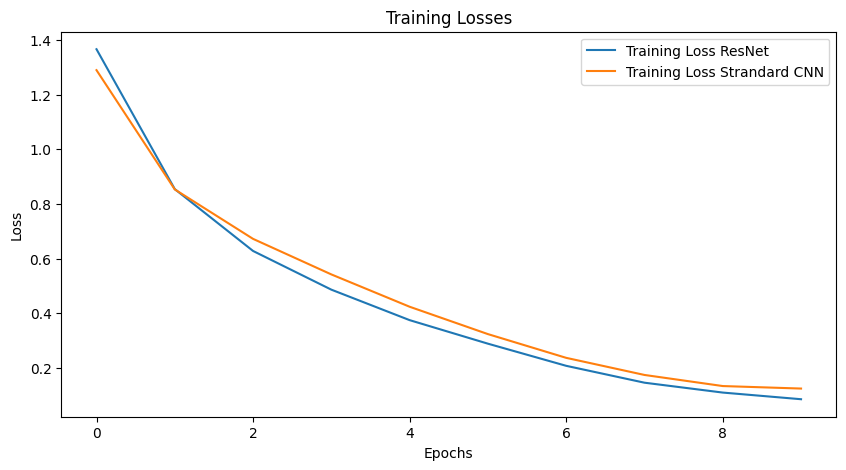

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(train_losses_r, train_losses_s):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses_r, label='Training Loss ResNet')
    plt.plot(train_losses_s, label='Training Loss Strandard CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training Losses')
    plt.legend()
    plt.show()


plot_loss_curves(train_losses_resnet, train_losses_standard)


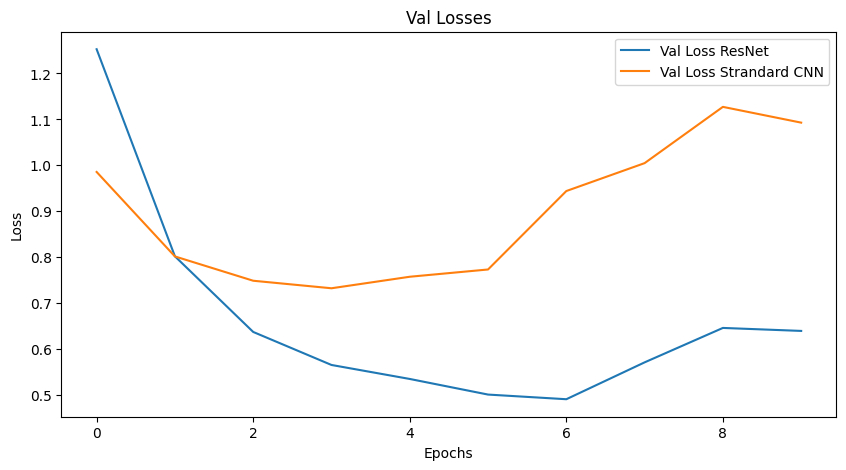

In [ ]:

def plot_loss_curves(val_losses_r, val_losses_s):
    plt.figure(figsize=(10, 5))
    plt.plot(val_losses_r, label='Val Loss ResNet')
    plt.plot(val_losses_s, label='Val Loss Strandard CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Val Losses')
    plt.legend()
    plt.show()


plot_loss_curves(val_losses_resnet, val_losses_standard)

In [ ]:
# Statistical analysis of gradient norms
def analyze_gradients(gradients_list):
    norms = []
    for grad_dict in gradients_list:
        for key, value in grad_dict.items():
            norms.append(value)

    mean = sum(norms) / len(norms)
    std_dev = (sum([(x - mean) ** 2 for x in norms]) / len(norms)) ** 0.5
    min_norm = min(norms)
    max_norm = max(norms)
    return mean, std_dev, min_norm, max_norm

cnn_mean, cnn_std, cnn_min, cnn_max = analyze_gradients(avg_gradients_standard)
resnet_mean, resnet_std, resnet_min, resnet_max = analyze_gradients(avg_gradients_resnet)

print(f"Standard CNN Gradients - Mean: {cnn_mean}, Std Dev: {cnn_std}, Min: {cnn_min}, Max: {cnn_max}")
print(f"ResNet Gradients - Mean: {resnet_mean}, Std Dev: {resnet_std}, Min: {resnet_min}, Max: {resnet_max}")


Standard CNN Gradients - Mean: 0.7714531687803802, Std Dev: 0.6568127785995637, Min: 0.02764975232348475, Max: 2.1797845261481106
ResNet Gradients - Mean: 0.10127445448684015, Std Dev: 0.22477093500601977, Min: 0.004875995128539383, Max: 2.5465151167586635


* For the standard CNN, the average gradient norm is significantly higher (0.771) compared to ResNet (0.101). This suggests that gradients in the standard CNN are generally larger, which could potentially lead to more volatile updates during training.

* The standard deviation of gradient norms for the standard CNN (0.657) is also notably higher than that of ResNet (0.225). Higher standard deviation indicates greater variability in gradient norms across different layers of the network.


* ResNet's lower mean and standard deviation of gradient norms suggest that it may alleviate the vanishing gradient problem better than the standard CNN. This could be attributed to ResNet's skip connections (identity mappings) which facilitate better gradient propagation through the network.
* The narrower range of gradient norms in ResNet implies more stable training dynamics, potentially leading to more consistent updates and faster convergence during training.

In [ ]:
import matplotlib.pyplot as plt

def organize_gradients(gradients):
    organized_grads = {}
    for grad_dict in gradients:
        for key, value in grad_dict.items():
            if key not in organized_grads:
                organized_grads[key] = []
            organized_grads[key].append(value)
    return organized_grads

organized_grads_standard = organize_gradients(avg_gradients_standard)
organized_grads_resnet = organize_gradients(avg_gradients_resnet)

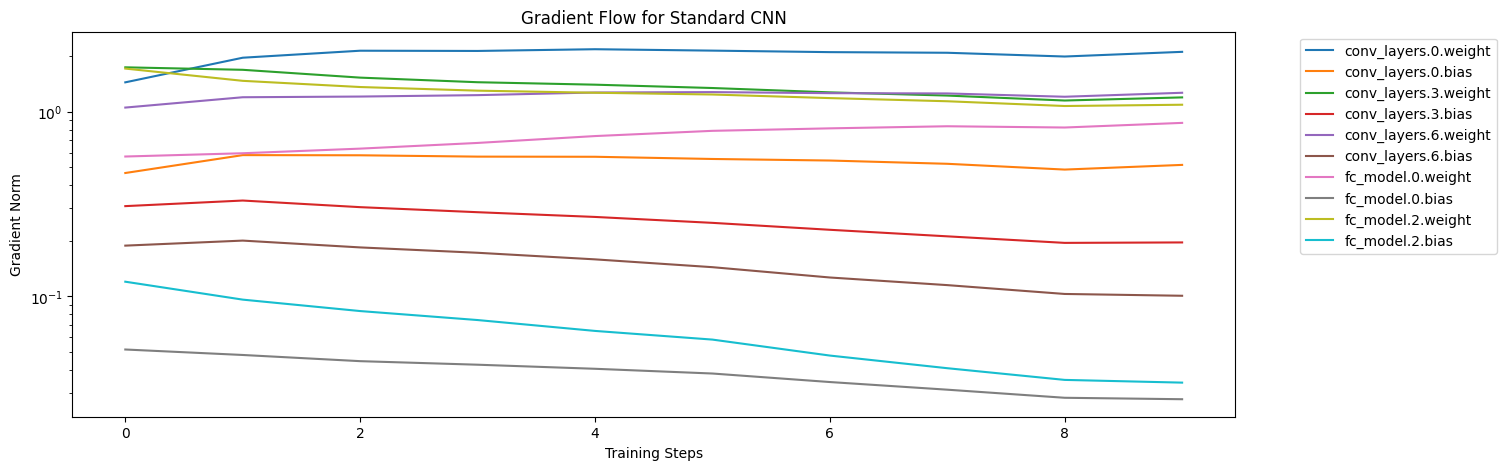

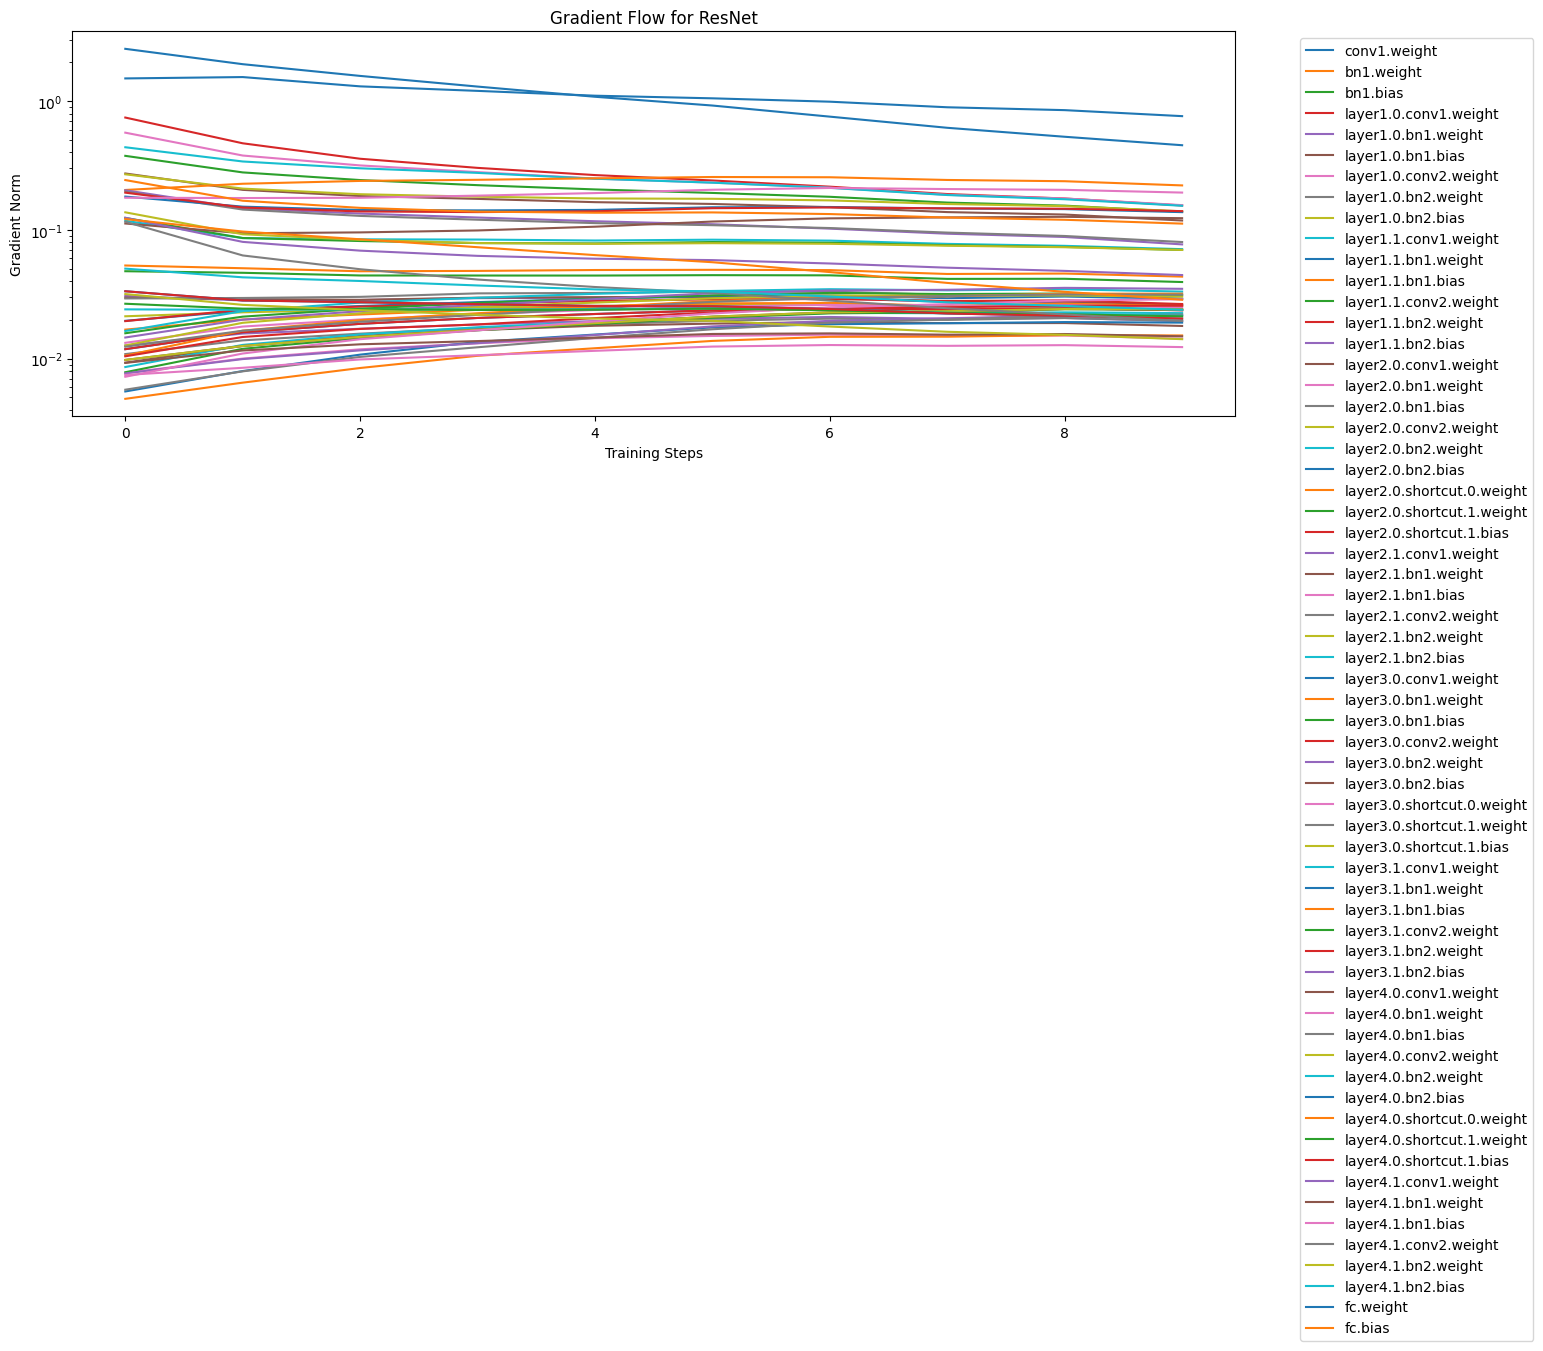

In [ ]:
def plot_gradient_flow(organized_grads, model_name):
    plt.figure(figsize=(15, 5))
    for name, grads in organized_grads.items():
        plt.plot(grads, label=name)
    plt.xlabel('Training Steps')
    plt.ylabel('Gradient Norm')
    plt.title(f'Gradient Flow for {model_name}')
    plt.yscale('log')  # Use logarithmic scale to better visualize gradients
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()


plot_gradient_flow(organized_grads_standard, 'Standard CNN')
plot_gradient_flow(organized_grads_resnet, 'ResNet')

The narrowing of gradient flow suggests that ResNet maintains more consistent gradients across its layers during training. This stability is beneficial because it leads to more predictable updates to network parameters, potentially accelerating convergence to a good solution.

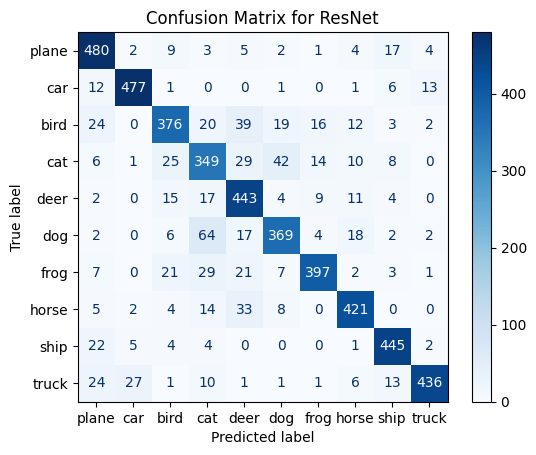

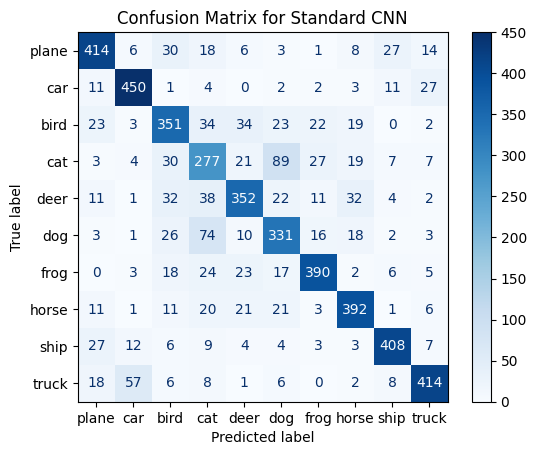

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_loader, classes, device, model_name):
    all_preds = torch.tensor([])
    all_labels = torch.tensor([])

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0)
            all_labels = torch.cat((all_labels, labels.cpu()), dim=0)

    cm = confusion_matrix(all_labels.numpy(), all_preds.numpy())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()


# classes should be a list of class names
plot_confusion_matrix(model_resnet, test_loader_cifar, classes, device, "ResNet")
plot_confusion_matrix(model_standard, test_loader_cifar, classes, device, "Standard CNN")

As shown with the confusion matrix table the ResNet is more effective, can distinguish better between object and animal than the CNN.



IN THE NEXT TWO EXERCISES I WILL USE THE CNN [32, 64, 128] AS THE PRE-TRAINED MODEL

In [24]:
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(num_epochs):
        # Train the model
        train_loss, train_acc = model.train_model(train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validate the model
        val_loss, val_acc = model.validate_model(val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Print progress
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    return train_losses, val_losses, val_accs

def test(model, test_loader, device):
    test_acc = model.test_model(test_loader, device)
    print(f'Test Accuracy: {test_acc:.2f}%')
    return test_acc


In [25]:

cnn_model = CNNModel(layer_channels=[32, 64, 128], fc_sizes=[512], output_size=10)
cnn_model.to(device)

optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses_cnn, val_losses_cnn, val_accs_cnn = train(cnn_model, train_loader_cifar, val_loader_cifar,
                                                       criterion, optimizer_cnn, device)

test_acc_cnn = test(cnn_model, test_loader_cifar, device)

Epoch [1/10], Train Loss: 1.2833, Train Acc: 53.83%, Val Loss: 0.9799, Val Acc: 65.22%
Epoch [2/10], Train Loss: 0.8552, Train Acc: 69.84%, Val Loss: 0.8897, Val Acc: 68.88%
Epoch [3/10], Train Loss: 0.6733, Train Acc: 76.40%, Val Loss: 0.8082, Val Acc: 71.94%
Epoch [4/10], Train Loss: 0.5310, Train Acc: 81.49%, Val Loss: 0.7103, Val Acc: 76.10%
Epoch [5/10], Train Loss: 0.4039, Train Acc: 85.83%, Val Loss: 0.7477, Val Acc: 75.82%
Epoch [6/10], Train Loss: 0.2931, Train Acc: 89.55%, Val Loss: 0.8104, Val Acc: 75.52%
Epoch [7/10], Train Loss: 0.2071, Train Acc: 92.57%, Val Loss: 0.9691, Val Acc: 75.34%
Epoch [8/10], Train Loss: 0.1537, Train Acc: 94.58%, Val Loss: 1.0668, Val Acc: 75.42%
Epoch [9/10], Train Loss: 0.1231, Train Acc: 95.63%, Val Loss: 1.1091, Val Acc: 75.62%
Epoch [10/10], Train Loss: 0.1052, Train Acc: 96.32%, Val Loss: 1.2472, Val Acc: 75.00%
Test Accuracy: 74.62%


### Exercise 2.2: Fully-convolutionalize a network.
Take one of your trained classifiers and **fully-convolutionalize** it. That is, turn it into a network that can predict classification outputs at *all* pixels in an input image. Can you turn this into a **detector** of handwritten digits? Give it a try.

**Hint 1**: Sometimes the process of fully-convolutionalization is called "network surgery".

**Hint 2**: To test your fully-convolutionalized networks you might want to write some functions to take random MNIST samples and embed them into a larger image (i.e. in a regular grid or at random positions).

In [ ]:
# Your code here.

In [135]:
# Convert the CNN model to a fully convolutional network (FCN)
class FullyConvCNN(nn.Module):
    def __init__(self, cnn_model):
        super(FullyConvCNN, self).__init__()
        self.conv_layers = cnn_model.conv_layers

        # Replace fully connected layers with conv layers
        self.conv_fc_layers = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(512, 10, kernel_size=1)  # 10 output classes for MNIST
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.conv_fc_layers(x)
        return x

In [133]:
# Convert the CNN model to a fully convolutional network (FCN)
class FullyConvCNN(nn.Module):
    def __init__(self, cnn_model):
        super(FullyConvCNN, self).__init__()
        self.conv_layers = cnn_model.conv_layers

        # Replace fully connected layers with conv layers
        self.conv_fc_layers = nn.Sequential(
            nn.Conv2d(128, 512, kernel_size=32),
            nn.ReLU(),
            nn.Conv2d(512, 10, kernel_size=1)  # 10 output classes for MNIST
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.conv_fc_layers(x)
        return x



In [136]:
# Embed MNIST samples into a larger image
def embed_mnist_samples(images, larger_image_size=(128, 128), num_samples=10):
    larger_image = torch.zeros((images.size(0), 3, *larger_image_size), dtype=images.dtype)
    for i in range(images.size(0)):
        for _ in range(num_samples):
            x, y = torch.randint(0, larger_image_size[0] - 28, (2,))
            larger_image[i, :, x:x+28, y:y+28] = images[i]
    return larger_image




In [137]:
# Initialize the FCN model
fcn_model = FullyConvCNN(cnn_model)
fcn_model.to(device)

FullyConvCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_fc_layers): Sequential(
    (0): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [138]:
# Sample a random MNIST image
mnist_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
mnist_loader = torch.utils.data.DataLoader(mnist_dataset, batch_size=1, shuffle=True)
mnist_iter = iter(mnist_loader)
mnist_image, mnist_label = next(mnist_iter)

In [9]:
# Convert them to 3 channels by repeating the single channel
mnist_images = mnist_image.repeat(1, 3, 1, 1)
larger_images = embed_mnist_samples(mnist_images)

In [30]:
# Pass the larger image through the FCN model
outputs = fcn_model(larger_images)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


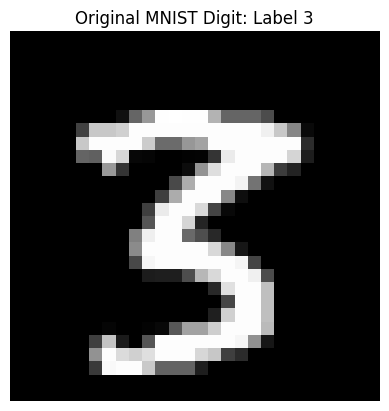

In [10]:
# Plot the original MNIST image
plt.figure()
plt.title(f"Original MNIST Digit: Label {mnist_label.item()}")
plt.imshow(mnist_image.squeeze(), cmap='gray')
plt.axis('off')
plt.show()

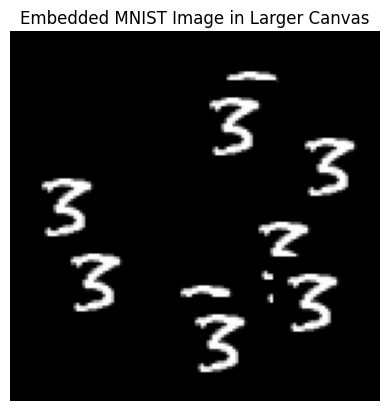

In [13]:
# Plot the embedded image
plt.figure()
plt.title("Embedded MNIST Image in Larger Canvas")
plt.imshow(larger_images[0].permute(1, 2, 0))
plt.axis('off')
plt.show()

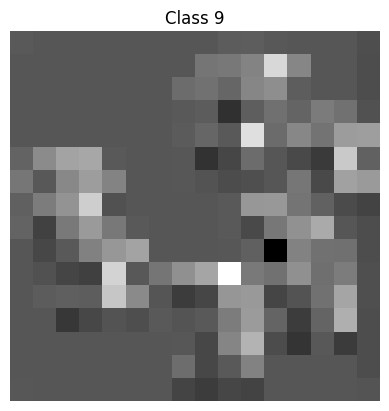

In [31]:
# Plot the output
plt.figure()
plt.title("Model Output")


plt.imshow(outputs[0, 0].detach().cpu().numpy(), cmap='gray')

plt.axis('off')
plt.show()

We turned the CNN into a detector of a handwritten digits, this exercise can be improved by training the model on a set of embedded images first.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

In [ ]:
# Your code here.

In [44]:
print(cnn_model.conv_layers)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [47]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from skimage.io import imread
from skimage.transform import resize

In [52]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None

        #PRETRAINED MODEL
        self.pretrained = cnn_model
        self.layerhook.append(self.pretrained.conv_layers[-3].register_forward_hook(self.forward_hook())) # the last convolution layer

        for p in self.pretrained.parameters():
            p.requires_grad = True

    def activations_hook(self,grad):
        self.gradients = grad

    def get_act_grads(self):
        return self.gradients

    def forward_hook(self):
        def hook(module, inp, out):
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook

    def forward(self,x):
        out = self.pretrained(x)
        return out, self.selected_out

In [76]:
val_loader_cifar2 = torch.utils.data.DataLoader(val_dataset_cifar, batch_size=1, shuffle=False)

# Load an example image from the validation set
image, label = next(iter(val_loader_cifar2))
image, label = image.to(device), label.to(device)

original_image = image[0]

Compute Gradient Class Activation Maps for the class SHIP

In [78]:
gcmodel = GradCamModel().to(device)

In [79]:
out, acts = gcmodel(image)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


In [80]:
acts = acts.detach().cpu()

In [77]:
print(label)

tensor([8])


In [81]:

batch_size = out.size(0)  # Get the batch size from the model output
num_classes = out.size(1)  # Get the number of classes from the model output

# Create a target tensor with the same batch size as the input
# Ensure target values are within the range [0, num_classes-1]
target_class_index = 8

if target_class_index >= num_classes:
    raise ValueError(f"Target class index {target_class_index} is out of range for {num_classes} classes")

target = torch.full((batch_size,), target_class_index, dtype=torch.long).to(device)

# Calculate loss
loss = nn.CrossEntropyLoss()(out, target)
loss.backward()

# Get gradients from the GradCAM model
grads = gcmodel.get_act_grads().detach().cpu()

# Pool the gradients across the batch and spatial dimensions
pooled_grads = torch.mean(grads, dim=[0, 2, 3]).detach().cpu()


In [82]:

for i in range(acts.shape[1]):
    acts[:, i, :, :] *= pooled_grads[i]

In [83]:
heatmap_j = torch.mean(acts, dim = 1).squeeze()

In [84]:
heatmap_j_max = heatmap_j.max(axis = 0)[0]

In [85]:
heatmap_j /= heatmap_j_max

In [86]:
cmap = mpl.cm.get_cmap("jet",256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.2)

<ipython-input-86-3d7060dcaa6e>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap("jet",256)


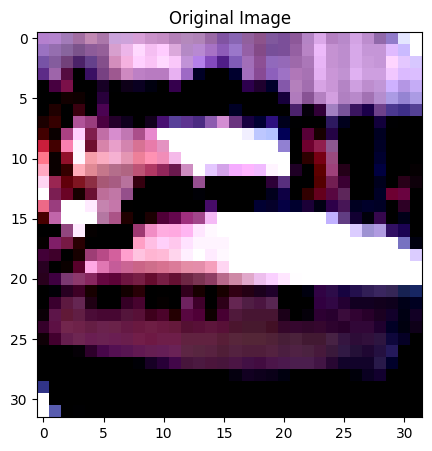

In [125]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow(original_image.permute(1, 2, 0).cpu().numpy())
# axs.imshow(heatmap_j2, cmap='jet', alpha=0.1)
plt.title("Original Image")
plt.show()

In [123]:
# Resize Heatmap

heatmap_j3 = resize(heatmap_j2,(32,32),preserve_range=True)

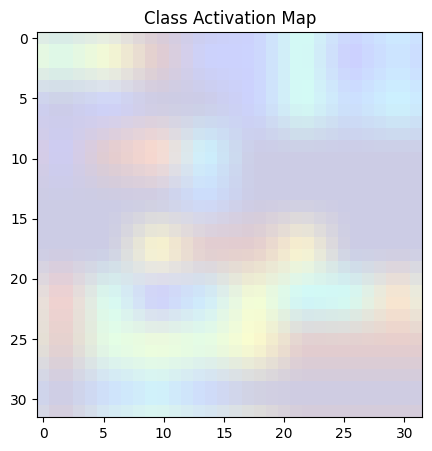

In [126]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
# axs.imshow(original_image.permute(1, 2, 0).cpu().numpy())
axs.imshow(heatmap_j3)
plt.title("Class Activation Map")
plt.show()

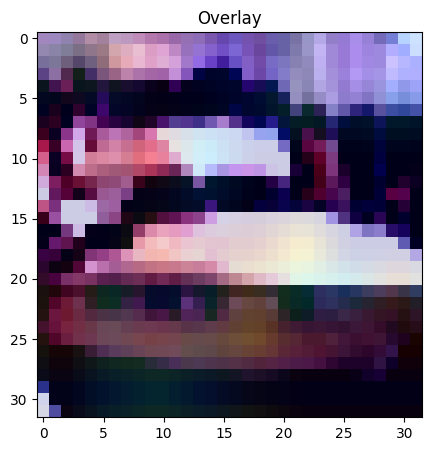

In [127]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow(original_image.permute(1, 2, 0).cpu().numpy())
axs.imshow(heatmap_j3)
plt.title("Overlay")
plt.show()

This output shows us the specific parts of the image the model focus on to detect the object!